In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GlobalAveragePooling1D, Activation, Conv1D, MaxPooling1D, Input, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import os
import glob
import json
import matplotlib.pyplot as plt

# Đặt seed để tái lập kết quả
tf.random.set_seed(42)
np.random.seed(42)

In [12]:
# 1. Các biến cấu hình
DATA_DIR = 'Data'
BATCH_SIZE = 32  # Giảm batch size để cập nhật trọng số thường xuyên hơn
AUTOTUNE = tf.data.AUTOTUNE
SEQ_LEN = 60
N_FEATURES = 201 # Khớp với dữ liệu đã tạo (pad 0)

# Load label map
with open('Logs/label_map.json', 'r', encoding='utf-8') as f:
    label_map = json.load(f)
NUM_CLASSES = len(label_map)
print(f"Classes: {list(label_map.keys())}")

def list_npz(split):
    pattern = os.path.join(DATA_DIR, split, 'class_*', '*.npz')
    files = sorted(glob.glob(pattern))
    # Shuffle file list để không bị bias thứ tự
    np.random.shuffle(files)
    return files

train_files = list_npz('train')
val_files   = list_npz('valid')
test_files  = list_npz('test')

print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

# --- Hàm Augmentation (QUAN TRỌNG ĐỂ CẢI THIỆN MODEL) ---
def augment_data(x, y):
    # 1. Thêm nhiễu Gaussian ngẫu nhiên
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.02, dtype=tf.float32)
    x = x + noise
    
    # 2. Scale ngẫu nhiên (phóng to/thu nhỏ biên độ chuyển động)
    scale = tf.random.uniform(shape=[], minval=0.9, maxval=1.1, dtype=tf.float32)
    x = x * scale
    return x, y

# --- Hàm load dữ liệu ---
def _load_npz(path):
    npz_path = path.decode('utf-8')
    data = np.load(npz_path)
    seq = data['sequence'].astype(np.float32)
    lbl = np.int32(data['label'])
    
    # Reshape nếu cần
    if seq.ndim == 1:
        seq = seq.reshape(SEQ_LEN, N_FEATURES)
    return seq, lbl

def parse_fn(path):
    seq, lbl = tf.numpy_function(func=_load_npz, inp=[path], Tout=[tf.float32, tf.int32])
    seq.set_shape([SEQ_LEN, N_FEATURES])
    lbl.set_shape([])
    return seq, lbl

def make_dataset(file_list, shuffle=False, repeat=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    if shuffle:
        ds = ds.shuffle(len(file_list))
    
    ds = ds.map(parse_fn, num_parallel_calls=AUTOTUNE)
    
    # Chỉ augment tập train
    if augment:
        ds = ds.map(augment_data, num_parallel_calls=AUTOTUNE)
        
    if repeat:
        ds = ds.repeat()
        
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    return ds

# Tạo dataset
train_ds = make_dataset(train_files, shuffle=True, repeat=True, augment=True) # Bật Augment
val_ds   = make_dataset(val_files, shuffle=False, repeat=False, augment=False)
test_ds  = make_dataset(test_files, shuffle=False, repeat=False, augment=False)

steps_per_epoch  = len(train_files) // BATCH_SIZE
validation_steps = len(val_files) // BATCH_SIZE
test_steps       = len(test_files) // BATCH_SIZE

Classes: ['A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'L']
Train: 4708 | Val: 825 | Test: 465


In [13]:
def build_model():
    inputs = Input(shape=(SEQ_LEN, N_FEATURES), name='input')
    
    # 1. Normalization: Chuẩn hóa dữ liệu đầu vào
    x = tf.keras.layers.Normalization(axis=-1, name='norm')(inputs)
    
    # 2. Spatial Dropout: Drop toàn bộ feature map thay vì từng neuron lẻ tẻ
    x = SpatialDropout1D(0.2)(x)
    
    # 3. CNN Block: Trích xuất đặc trưng cục bộ (local features)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x) # Giảm chiều dài chuỗi đi một nửa -> tính toán nhanh hơn
    
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # 4. LSTM Block: Học sự phụ thuộc thời gian
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(x)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3))(x) # Return False để lấy vector cuối
    
    # 5. Dense Block
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x) # Dropout mạnh để chống overfitting
    
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

model = build_model()

# Adapt lớp Normalization với dữ liệu train
print("Adapting normalization layer...")
for batch_x, _ in train_ds.take(10): # Lấy 10 batch để tính mean/std
    model.get_layer('norm').adapt(batch_x)

# Compile với Label Smoothing
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

model.summary()

Adapting normalization layer...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 60, 201)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ norm (Normalization)            │ (None, 60, 201)        │           403 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 60, 201)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │        38,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 15, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,236 (1.95 MB)

 Trainable params: 509,193 (1.94 MB)

 Non-trainable params: 1,043 (4.08 KB)

In [14]:
checkpoint_dir = 'Models/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'best_model.keras')

callbacks = [
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1), # Tăng patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

In [15]:
# Train
history = model.fit(
    train_ds,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
print("\nEvaluating on Test set...")
if len(test_files) > 0:
    test_loss, test_acc = model.evaluate(test_ds, steps=test_steps, verbose=1)
    print(f"Test Accuracy: {test_acc:.4f}")

# Save Final
final_path = os.path.join('Models', 'sequence_cnn_lstm_final.keras')
model.save(final_path)
print(f"Saved final model to: {final_path}")

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3654 - loss: 1.8358
Epoch 1: val_accuracy improved from None to 0.82250, saving model to Models/checkpoints\best_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 50s 213ms/step - accuracy: 0.5117 - loss: 1.3631 - val_accuracy: 0.8225 - val_loss: 0.5055 - learning_rate: 0.0010
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7532 - loss: 0.7326
Epoch 2: val_accuracy improved from 0.82250 to 0.86000, saving model to Models/checkpoints\best_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.7736 - loss: 0.6587 - val_accuracy: 0.8600 - val_loss: 0.3447 - learning_rate: 0.0010
Epoch 3/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8282 - loss: 0.5116
Epoch 3: val_accuracy improved from 0.86000 to 0.95875, saving model to Models/checkpoints\best_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.8340 - loss: 0.4973 - val_accuracy: 0.9588 - val_loss: 0.1272 - learnin

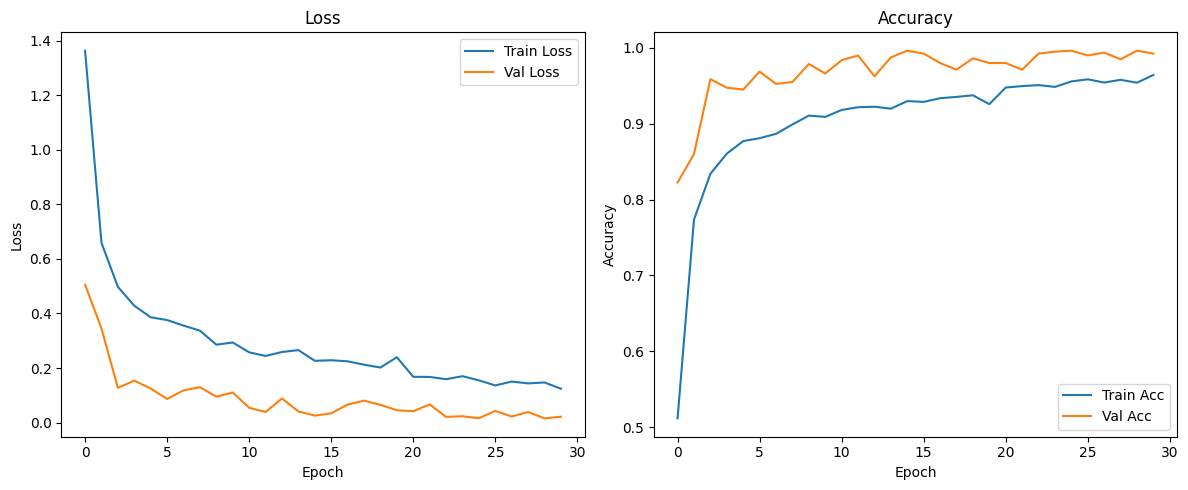

In [16]:
plt.figure(figsize=(12,5))

# Biểu đồ Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()